In [57]:
import numpy as np
import pandas as pd
import os

import torch

os.environ['CUDA_VISIBLE_DEVICES'] = "3"
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split, Dataset
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier
import skorch
from skorch import NeuralNetClassifier, NeuralNet, NeuralNetBinaryClassifier
import random
seed = 472

In [58]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(seed)

In [59]:
# 加载数据
cols = list(pd.read_csv("/hdd/wmh/other/Cookie_Thieft/feature/"
                        "LIWC-22 Results - all_Control_out - LIWC Analysis.csv").columns)[2:]
pos_cols = list(pd.read_csv("/hdd/wmh/other/Cookie_Thieft/feature/pos_tag.csv").columns)[3:]

A = cols.copy()

abnormal_dataset = pd.read_csv("/hdd/wmh/other/Cookie_Thieft/feature/merged_abnormal.csv")
normal_dataset = pd.read_csv("/hdd/wmh/other/Cookie_Thieft//feature/merged_normal.csv")

data = normal_dataset
data = pd.concat([abnormal_dataset, normal_dataset])

"""删除embed_ds 特征"""
print(data.shape)
print("================")
for col in cols + pos_cols:
    data = data.drop(col, axis=1)
# try 1
data = data.drop('Feature_4', axis=1)
# try 2 -- 保留
data = data.drop('words_num', axis=1)
# try 3
del_cols = ['Feature_2_high', 'Feature_2_mid-high', 'Feature_2_mid', 'Feature_2_low']
for col in del_cols:
    data = data.drop(col, axis=1)

print(data.shape)
print(list(data.columns))

# binary = ['sex', 'c_charge_degree']
# other = ['age', 'race', 'priors_count', 'length_of_stay']
binary = []
other = list(data.columns)[2:]
# other1 = ['Feature_1_high', 'Feature_1_mid-high', 'Feature_1_mid']# , 'Feature_1_low']
# other2 = ['Feature_2_high', 'Feature_2_mid-high']# , 'Feature_2_mid', 'Feature_2_low']
# other3 = [x for x in ['Feature_2_sink', 'Feature_2_dish', 'Feature_2_mother', 'Feature_2_stool',
#           'Feature_2_boy', 'Feature_2_water', 'Feature_2_jar', 'Feature_2_cookie'] if x in data.columns]

scaler = MinMaxScaler((-1, 1))
scaler = Normalizer()
scaler = StandardScaler()
data[other] = scaler.fit_transform(data[other])
# data[other] = scaler.fit_transform(data[other])

data_train, data_test = train_test_split(data, train_size=0.9, test_size=0.1, random_state=seed)
# print(data_train)

X_train, y_train = data_train[other + binary], data_train['label']
# X_valid, y_valid = data_valid[other + binary], data_valid['label']
X_test, y_test = data_test[other + binary], data_test['label']

(549, 90)
(549, 30)
['sample', 'label', 'Feature_1_high', 'Feature_1_mid-high', 'Feature_1_mid', 'Feature_1_low', 'Feature_2_mother', 'Feature_2_jar', 'Feature_2_dish', 'Feature_2_cookie', 'Feature_2_water', 'Feature_2_stool', 'Feature_2_boy', 'Feature_2_sink', 'Feature_2_window', 'Feature_2_cabinet', 'Feature_2_cup', 'Feature_2_plant', 'Feature_2_girl', 'Feature_2_curtain', 'Feature_2_floor', 'Feature_3', 'log_embed_ds', 'sentence_num', 'word_per_sentence', 'group1_score', 'group2_score', 'group3_score', 'group4_score', 'avg_clip_score']


In [60]:
data

,sample,label,Feature_1_high,Feature_1_mid-high,Feature_1_mid,Feature_1_low,Feature_2_mother,Feature_2_jar,Feature_2_dish,Feature_2_cookie,...,Feature_2_floor,Feature_3,log_embed_ds,sentence_num,word_per_sentence,group1_score,group2_score,group3_score,group4_score,avg_clip_score
0,001-0,1,-0.456812,-0.344388,-0.681369,-0.200220,-0.794978,0.008452,0.388588,-1.334539,...,-0.697974,0.282012,-0.393374,-0.541759,0.257992,-0.849105,-0.075177,-0.589018,1.055609,0.251276
1,001-2,1,0.276491,-0.944713,-0.681369,-0.200220,-0.274784,1.168488,-0.581116,-1.334539,...,-0.697974,-0.987041,0.921305,0.333390,-0.218434,-1.023460,-0.371266,-0.589018,-1.059256,-1.131155
2,003-0,1,-1.190116,1.452390,1.379630,-0.200220,0.245410,1.168488,-1.550820,-1.334539,...,2.261004,1.551065,0.493909,1.333561,0.171493,-1.200789,-0.174119,1.592157,0.801364,1.226056
3,005-0,1,0.276491,-0.944713,-0.681369,-0.200220,0.245410,-1.151584,-0.581116,-0.323971,...,-0.697974,-0.987041,-1.050713,-0.541759,-0.751388,-0.576678,0.351165,-0.589018,-1.059256,-0.988062
4,005-2,1,-1.923419,-1.545038,-0.681369,-0.200220,-0.274784,-1.151584,-1.550820,-1.334539,...,-0.697974,-0.987041,2.715866,0.208369,-2.196359,1.387663,-0.482096,-0.589018,-1.059256,-0.918173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,686-0,0,0.276491,2.052715,3.440629,4.578936,-0.274784,2.328525,0.388588,0.686597,...,0.781515,1.551065,-0.158431,-0.416738,3.470676,0.429596,0.331897,1.765630,0.896807,1.604799
239,688-0,0,-0.456812,-0.344388,-0.681369,-0.200220,-0.794978,-1.151584,-0.581116,-0.323971,...,-0.697974,0.282012,-0.720794,-0.416738,0.321448,0.950717,-0.397410,-0.589018,1.021071,0.355210
240,691-0,0,-0.456812,2.052715,2.410130,-0.200220,2.326186,-1.151584,0.388588,-0.323971,...,0.781515,1.551065,0.333948,0.583433,0.502057,-0.940829,-0.017684,1.486356,0.823949,1.229350
241,709-0,0,0.276491,-0.344388,-0.681369,-0.200220,-0.274784,0.008452,-0.581116,-1.334539,...,0.781515,0.282012,-0.053457,-0.416738,0.021485,0.275369,-0.671162,1.634297,-1.059256,0.154017


In [4]:
from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier
model = NAMClassifier(
        num_epochs=300,
        num_learners=5,
        metric='neg_log_loss',
        early_stop_mode='min',
        monitor_loss=True,
        lr=1e-3,
        hidden_sizes=[32, 16],
        batch_size=8,
        val_split=0.1,
        n_jobs=16,
        random_state=42,
        decay_rate=1e-4,
        warm_start=True,
        device='cuda',
    )
model.load_checkpoints(f'/hdd/wmh/other/Cookie_Thieft/nam/output/ours/{seed}/')

In [5]:
# Evaluate performance of the best model on test set
y_true, y_pred = y_test, model.predict(X_test)
y_prob = model.predict_proba(X_test) 

In [6]:
# Performance Metrics: AUC, ACC, Recall, Precision, F1_score
metrics = [round(roc_auc_score(y_true, y_prob[:]), 4), round(accuracy_score(y_true, y_pred), 4),
           round(recall_score(y_true, y_pred), 4), round(precision_score(y_true, y_pred), 4),
           round(f1_score(y_true, y_pred), 4),
           ]

print('Accuracy metrics')
print('AUC, ACC, Recall, Precision, F1_score')
print(metrics)

Accuracy metrics
AUC, ACC, Recall, Precision, F1_score
[0.9352, 0.8727, 0.963, 0.8125, 0.8814]


In [7]:
#@title Dataset helpers
def load_col_min_max(dataset_name):
    """Loads the dataset according to the `dataset_name` passed."""
    # 加载数据
    cols = list(pd.read_csv("/hdd/wmh/other/Cookie_Thieft/feature/"
                            "LIWC-22 Results - all_Control_out - LIWC Analysis.csv").columns)[2:]
    pos_cols = list(pd.read_csv("/hdd/wmh/other/Cookie_Thieft/feature/pos_tag.csv").columns)[3:]

    cols += pos_cols
    
    A = cols.copy()
    
    abnormal_dataset = pd.read_csv("/hdd/wmh/other/Cookie_Thieft/feature/merged_abnormal.csv")
    normal_dataset = pd.read_csv("/hdd/wmh/other/Cookie_Thieft//feature/merged_normal.csv")
    
    data = normal_dataset
    data = pd.concat([abnormal_dataset, normal_dataset])

    
    """删除embed_ds 特征"""
    print(data.shape)
    print("================")
    for col in cols:
        data = data.drop(col, axis=1)
    # try 1
    data = data.drop('Feature_4', axis=1)
    # try 2 -- 保留
    data = data.drop('words_num', axis=1)
    # try 3
    del_cols = ['Feature_2_high', 'Feature_2_mid-high', 'Feature_2_mid', 'Feature_2_low']
    for col in del_cols:
        data = data.drop(col, axis=1)

    print(data.shape)
    print(list(data.columns))
    
    binary = []
    other = list(data.columns)[2:]
    x = data[other + binary]
    
    col_min_max = {}
    for col in x:
        unique_vals = x[col].unique()
        col_min_max[col] = (np.min(unique_vals), np.max(unique_vals))
    return col_min_max

def inverse_min_max_scaler(x, min_val, max_val):
    return (x + 1)/2 * (max_val - min_val) + min_val

In [8]:
def load_dataset(dataset_name):
    cols = list(pd.read_csv("../feature/LIWC-22 Results - all_Control_out - LIWC Analysis.csv").columns)[2:]
    pos_cols = list(pd.read_csv("/hdd/wmh/other/Cookie_Thieft/feature/pos_tag.csv").columns)[3:]

    cols += pos_cols
    A = cols.copy()
    abnormal_dataset = pd.read_csv("/hdd/wmh/other/Cookie_Thieft/feature/merged_abnormal_0.75.csv")
    normal_dataset = pd.read_csv("/hdd/wmh/other/Cookie_Thieft//feature/merged_normal_0.75.csv")
    
    abnormal_dataset = pd.read_csv("../feature/merged_abnormal.csv")
    normal_dataset = pd.read_csv("../feature/merged_normal.csv")

    data = normal_dataset
    data = pd.concat([abnormal_dataset, normal_dataset])
    
    """删除embed_ds 特征"""
    print(data.shape)
    print("================")
    for col in cols:
        data = data.drop(col, axis=1)
    # try 1
    data = data.drop('Feature_4', axis=1)
    # try 2 -- 保留
    data = data.drop('words_num', axis=1)
    # try 3
    del_cols = ['Feature_2_high', 'Feature_2_mid-high', 'Feature_2_mid', 'Feature_2_low']
    for col in del_cols:
        data = data.drop(col, axis=1)
    
    print(data.shape)
    print(list(data.columns))

    # binary = ['sex', 'c_charge_degree']
    # other = ['age', 'race', 'priors_count', 'length_of_stay']
    binary = []
    other = list(data.columns)[2:]
    # other1 = ['Feature_1_high', 'Feature_1_mid-high', 'Feature_1_mid']# , 'Feature_1_low']
    # other2 = ['Feature_2_high', 'Feature_2_mid-high']# , 'Feature_2_mid', 'Feature_2_low']
    # other3 = [x for x in ['Feature_2_sink', 'Feature_2_dish', 'Feature_2_mother', 'Feature_2_stool',
    #           'Feature_2_boy', 'Feature_2_water', 'Feature_2_jar', 'Feature_2_cookie'] if x in data.columns]
    
    scaler = MinMaxScaler((-1, 1))
    scaler = Normalizer()
    scaler = StandardScaler()
    # data[other] = scaler.fit_transform(data[other])
    data[other] = scaler.fit_transform(data[other])
    
    # data_train, data_test = train_test_split(data, train_size=0.8, test_size=0.2, random_state=42)
    
    # data_train, data_tmp, _, _ = train_test_split(data, list(data['label']),
    #                                         test_size=0.2, random_state=42, stratify=data['label'])
    # data_valid, data_test, _, _ = train_test_split(data_tmp, data_tmp.label.astype('int'),
    #                                         test_size=0.5, random_state=42, stratify=data_tmp.label)
    
    # X_train, y_train = data_train[other + binary], data_train['label']
    # # X_valid, y_valid = data_valid[other + binary], data_valid['label']
    # X_test, y_test = data_test[other + binary], data_test['label']
    data_x = data[other + binary]
    column_names = list(data_x)
    data_x = np.array(data_x).astype(np.float32)
    data_y = data['label']
    
    if not isinstance(data_y, np.ndarray):
        data_y = pd.get_dummies(data_y).values
        data_y = np.argmax(data_y, axis=-1)
        data_y = data_y.astype('float32')
    return data_x, data_y, column_names

In [9]:
#@title Load dataset
dataset_name = 'Cookie' #@param {'type': 'string'}
data =  load_dataset(dataset_name)
data_x, data_y, column_names = data
#data_x, data_y, column_names = load_recidivism_data('/hde/gwc_data/')
col_min_max = load_col_min_max(dataset_name)

(549, 90)
(549, 30)
['sample', 'label', 'Feature_1_high', 'Feature_1_mid-high', 'Feature_1_mid', 'Feature_1_low', 'Feature_2_mother', 'Feature_2_jar', 'Feature_2_dish', 'Feature_2_cookie', 'Feature_2_water', 'Feature_2_stool', 'Feature_2_boy', 'Feature_2_sink', 'Feature_2_window', 'Feature_2_cabinet', 'Feature_2_cup', 'Feature_2_plant', 'Feature_2_girl', 'Feature_2_curtain', 'Feature_2_floor', 'Feature_3', 'log_embed_ds', 'sentence_num', 'word_per_sentence', 'group1_score', 'group2_score', 'group3_score', 'group4_score', 'avg_clip_score']
(549, 90)
(549, 30)
['sample', 'label', 'Feature_1_high', 'Feature_1_mid-high', 'Feature_1_mid', 'Feature_1_low', 'Feature_2_mother', 'Feature_2_jar', 'Feature_2_dish', 'Feature_2_cookie', 'Feature_2_water', 'Feature_2_stool', 'Feature_2_boy', 'Feature_2_sink', 'Feature_2_window', 'Feature_2_cabinet', 'Feature_2_cup', 'Feature_2_plant', 'Feature_2_girl', 'Feature_2_curtain', 'Feature_2_floor', 'Feature_3', 'log_embed_ds', 'sentence_num', 'word_per_sen

In [10]:
col_min_max

{'Feature_1_high': (0.125, 1.0),
 'Feature_1_mid-high': (0.0, 1.0),
 'Feature_1_mid': (0.0, 0.75),
 'Feature_1_low': (0.0, 0.222),
 'Feature_2_mother': (0, 15),
 'Feature_2_jar': (0, 5),
 'Feature_2_dish': (0, 8),
 'Feature_2_cookie': (0, 5),
 'Feature_2_water': (0, 4),
 'Feature_2_stool': (0, 4),
 'Feature_2_boy': (0, 15),
 'Feature_2_sink': (0, 5),
 'Feature_2_window': (0, 5),
 'Feature_2_cabinet': (0, 7),
 'Feature_2_cup': (0, 2),
 'Feature_2_plant': (0, 7),
 'Feature_2_girl': (0, 13),
 'Feature_2_curtain': (0, 3),
 'Feature_2_floor': (0, 6),
 'Feature_3': (0.25, 1.0),
 'log_embed_ds': (0.0122, 0.2946),
 'sentence_num': (4, 105),
 'word_per_sentence': (2.3333, 15.875),
 'group1_score': (0.0, 28.7233),
 'group2_score': (0.0, 30.5827),
 'group3_score': (0.0, 26.6377),
 'group4_score': (0.0, 27.8953),
 'avg_clip_score': (4.9112, 25.2025)}

In [11]:
#@title Helper functions for generating predictions
import torch
def partition(lst, batch_size):
    lst_len = len(lst)
    index = 0
    while index < lst_len:
      x = lst[index: batch_size + index]
      index += batch_size
      yield x

def generate_predictions(gen, nn_model):
  y_pred = []
  while True:
    try:
      x = next(gen)
      #pred = nn_model(x).numpy()
      pred = nn_model.predict_proba(x).numpy()
      y_pred.extend(pred)
    except:
      break
  return y_pred

def get_test_predictions(nn_model, x_test, batch_size=256):
  return list(nn_model.predict_proba(x_test))

def get_feature_predictions_old(nn_model, features, batch_size=256):
  """Get feature predictions for unique values for each feature."""
  unique_feature_pred, unique_feature_gen = [], []
  for i, feature in enumerate(features):
    batch_size = min(batch_size, feature.shape[0])
    generator = partition(feature, batch_size)
    feature_pred = lambda x: nn_model.feature_nns[i](
        x, training=nn_model._false)  # pylint: disable=protected-access
    unique_feature_gen.append(generator)
    unique_feature_pred.append(feature_pred)

  feature_predictions = [
      generate_predictions(generator, feature_pred) for
      feature_pred, generator in zip(unique_feature_pred, unique_feature_gen)
  ]
  feature_predictions = [np.array(x) for x in feature_predictions]
  return feature_predictions

def get_feature_predictions(nn_model, dataset_name):
    feature_predictions = []
    unique_features = compute_features(dataset_name)
    for c, i in enumerate(unique_features):
        tmp = []
        for k in range(5):
            f_preds = nn_model.models[k].feature_nns[c](torch.Tensor(i).to('cuda'))
            tmp.append(f_preds.squeeze().cpu().detach().numpy())
        tmp_array = np.array(tmp)
        #print(tmp_array.shape)
        average_list = np.mean(tmp_array, axis=0)
        feature_predictions.append(average_list)
    return feature_predictions

def compute_features(dataset_name):
    x_data, _, _ = load_dataset(dataset_name)
    print("===")
    print(x_data.shape)
    single_features = np.split(x_data, x_data.shape[1], axis=1)
    unique_features = [np.unique(f, axis=0) for f in single_features]
    return unique_features

In [12]:
#@title Calculate individual feature and test predictions
test_predictions = get_test_predictions(model, X_test)

In [13]:
len(test_predictions)

55

In [14]:
unique_features = compute_features('Cookie')

(549, 90)
(549, 30)
['sample', 'label', 'Feature_1_high', 'Feature_1_mid-high', 'Feature_1_mid', 'Feature_1_low', 'Feature_2_mother', 'Feature_2_jar', 'Feature_2_dish', 'Feature_2_cookie', 'Feature_2_water', 'Feature_2_stool', 'Feature_2_boy', 'Feature_2_sink', 'Feature_2_window', 'Feature_2_cabinet', 'Feature_2_cup', 'Feature_2_plant', 'Feature_2_girl', 'Feature_2_curtain', 'Feature_2_floor', 'Feature_3', 'log_embed_ds', 'sentence_num', 'word_per_sentence', 'group1_score', 'group2_score', 'group3_score', 'group4_score', 'avg_clip_score']
===
(549, 28)


In [15]:
print(len(unique_features[5]))

6


In [16]:
feature_predictions = get_feature_predictions(model, 'Cookie')

(549, 90)
(549, 30)
['sample', 'label', 'Feature_1_high', 'Feature_1_mid-high', 'Feature_1_mid', 'Feature_1_low', 'Feature_2_mother', 'Feature_2_jar', 'Feature_2_dish', 'Feature_2_cookie', 'Feature_2_water', 'Feature_2_stool', 'Feature_2_boy', 'Feature_2_sink', 'Feature_2_window', 'Feature_2_cabinet', 'Feature_2_cup', 'Feature_2_plant', 'Feature_2_girl', 'Feature_2_curtain', 'Feature_2_floor', 'Feature_3', 'log_embed_ds', 'sentence_num', 'word_per_sentence', 'group1_score', 'group2_score', 'group3_score', 'group4_score', 'avg_clip_score']
===
(549, 28)


In [17]:
print(len(feature_predictions))
print(len(feature_predictions[0]))

28
8


In [71]:
NUM_FEATURES = data_x.shape[1]
SINGLE_FEATURES = np.split(data_x, NUM_FEATURES, axis=1)
UNIQUE_FEATURES = [np.unique(x, axis=0) for x in SINGLE_FEATURES]

SINGLE_FEATURES_ORIGINAL = {}
UNIQUE_FEATURES_ORIGINAL = {}
for i, col in enumerate(column_names):
    min_val, max_val = col_min_max[col]
    UNIQUE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(
        UNIQUE_FEATURES[i][:, 0], min_val, max_val)
    SINGLE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(
        SINGLE_FEATURES[i][:, 0], min_val, max_val)

In [19]:
#@title Feature label mappings and column names
FEATURE_LABEL_MAPPING = {}
FEATURE_LABEL_MAPPING['Recidivism'] = {
    'race': (['African\nAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other'], 90),
    'sex': (['Female', 'Male'], None)
}
FEATURE_LABEL_MAPPING['Housing'] = {}

FEATURE_LABEL_MAPPING['Cookie'] = {}

#@title Column Names
COL_NAMES = {}
COL_NAMES['Recidivism'] = {
    'age' : 'Age',
    'race': 'Race',
    'sex': 'Gender',
    'priors_count': 'Prior Counts',
    'length_of_stay': 'Length of Stay',
    'c_charge_degree': 'Charge Degree'
  }
COL_NAMES['Cookie'] = {
    col: col
    for col in column_names
}

In [20]:
#@title Categorical Feature names
if dataset_name in ['Housing', 'Credit', 'Cookie']:
  CATEGORICAL_NAMES = []
elif dataset_name == 'Mimic2':
  CATEGORICAL_NAMES = ['AIDS','AdmissionType','GCS','Lymphoma',
                       'Temperature','MetastaticCancer','Renal']
elif dataset_name == 'Recidivism':
  CATEGORICAL_NAMES = ['race','sex','c_charge_degree']
elif dataset_name == 'Fico':
  CATEGORICAL_NAMES = ['delinquent', 'inquiry', 'MaxDelqEver', 'MaxDelq2PublicRecLast12M']
else:
  raise ValueError('{} not found!'.format(dataset_name))
# categorical_names = ['AIDS','AdmissionType','GCS','Lymphoma','Temperature','MetastaticCancer','Renal']

In [21]:
avg_hist_data = {col: predictions for col, predictions in zip(column_names, feature_predictions)}

In [62]:
avg_hist_data['sentence_num']

array([-0.1378569 , -0.12920715, -0.12097152, -0.11423206, -0.10756383,
       -0.09974745, -0.08967509, -0.07867049, -0.06688232, -0.05486638,
       -0.0439923 , -0.03409391, -0.02419138, -0.01383398, -0.00334194,
        0.0070069 ,  0.01882585,  0.03095339,  0.04585826,  0.06885899,
        0.09449282,  0.12798299,  0.16438775,  0.20305827,  0.24585065,
        0.28959098,  0.3333258 ,  0.42107624,  0.46577412,  0.51109916,
        0.5551635 ,  0.5977354 ,  0.6397852 ,  0.68181765,  0.7564207 ,
        0.81834394,  0.8474043 ,  0.9041109 ,  2.417911  ], dtype=float32)

In [42]:
for k,v in avg_hist_data.items():
    print(k)
    print(v.shape)

Feature_1_high
(8,)
Feature_1_mid-high
(8,)
Feature_1_mid
(6,)
Feature_1_low
(3,)
Feature_2_mother
(13,)
Feature_2_jar
(6,)
Feature_2_dish
(8,)
Feature_2_cookie
(6,)
Feature_2_water
(5,)
Feature_2_stool
(5,)
Feature_2_boy
(13,)
Feature_2_sink
(6,)
Feature_2_window
(6,)
Feature_2_cabinet
(8,)
Feature_2_cup
(3,)
Feature_2_plant
(6,)
Feature_2_girl
(12,)
Feature_2_curtain
(4,)
Feature_2_floor
(5,)
Feature_3
(4,)
log_embed_ds
(462,)
sentence_num
(39,)
word_per_sentence
(390,)
group1_score
(545,)
group2_score
(540,)
group3_score
(140,)
group4_score
(272,)
avg_clip_score
(545,)


In [23]:
ALL_INDICES = {}
MEAN_PRED = {}
for i, col in enumerate(column_names):
  x_i = data_x[:, i]
  ALL_INDICES[col] = np.searchsorted(UNIQUE_FEATURES[i][:, 0], x_i, 'left')
for col in column_names:
  MEAN_PRED[col] =  np.mean([avg_hist_data[col][i] for i in ALL_INDICES[col]])
print(MEAN_PRED)

{'Feature_1_high': 0.09286254, 'Feature_1_mid-high': -0.027216628, 'Feature_1_mid': -0.09598167, 'Feature_1_low': 0.0366586, 'Feature_2_mother': 0.053045873, 'Feature_2_jar': -0.052712515, 'Feature_2_dish': 0.02644943, 'Feature_2_cookie': 0.05103016, 'Feature_2_water': -0.033227205, 'Feature_2_stool': -0.0132460985, 'Feature_2_boy': 0.015501931, 'Feature_2_sink': 0.012832498, 'Feature_2_window': 0.010184583, 'Feature_2_cabinet': 0.05554127, 'Feature_2_cup': 0.028077222, 'Feature_2_plant': 0.0155083705, 'Feature_2_girl': 0.034631822, 'Feature_2_curtain': 0.036681294, 'Feature_2_floor': -0.015672773, 'Feature_3': -0.000761112, 'log_embed_ds': 0.06716032, 'sentence_num': 0.02436892, 'word_per_sentence': 0.049136177, 'group1_score': 0.02708565, 'group2_score': 0.06505757, 'group3_score': 0.044006374, 'group4_score': 0.011991431, 'avg_clip_score': 0.011658082}


In [24]:
#@title Helpers for MEAN feature importance
def compute_mean_feature_importance(avg_hist_data):
  mean_abs_score = {}
  for k in avg_hist_data:
    mean_abs_score[k] = np.mean(np.abs(avg_hist_data[k] - MEAN_PRED[k]))
  x1, x2 = zip(*mean_abs_score.items())
  return x1, x2
def plot_mean_feature_importance(x1, x2, width = 0.3):
  fig = plt.figure(figsize=(10, 4))
  ind = np.arange(len(x1))  # the x locations for the groups
  x1_indices = np.argsort(x2)
  cols_here = [cols[i] for i in x1_indices]
  # x1_here = [x12[i] for i in x1_indices]
  x2_here = [x2[i] for i in x1_indices]

  plt.bar(ind, x2_here, width, label='NAMs')
  # plt.bar(ind+width, x1_here, width, label='EBMs')
  plt.xticks(ind + width/2, cols_here, rotation=90, fontsize='small')
  plt.ylabel('Mean Absolute Score', fontsize='x-large')
  plt.legend(loc='upper right', fontsize='large')
  plt.title(f'Overall Importance: {dataset_name}', fontsize='x-large')
  plt.show()
  return fig

In [25]:
# import graph_builder
import os.path as osp
import numpy as np

import matplotlib.pyplot as plt

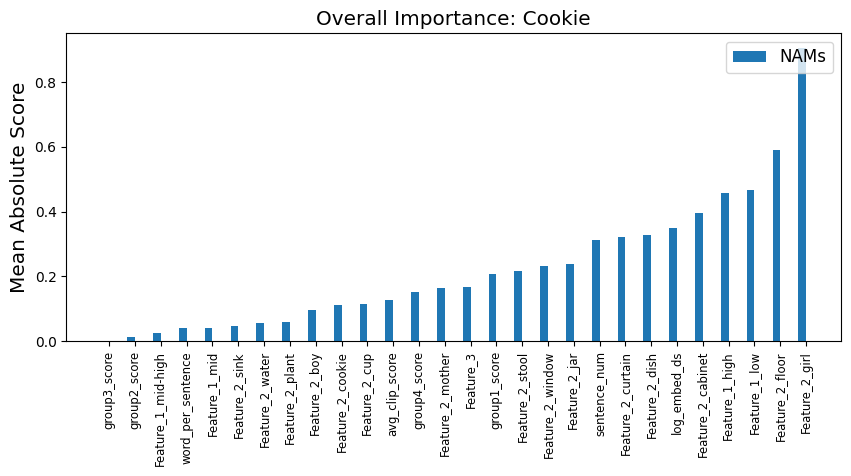

In [26]:
x1, x2 = compute_mean_feature_importance(avg_hist_data)
cols = [COL_NAMES[dataset_name][x] for x in x1]
fig = plot_mean_feature_importance(x1, x2)

In [27]:
if not os.path.exists(f"./explain/{seed}/"):
    os.makedirs(f"./explain/{seed}/")
fig.savefig(f'./explain/{seed}/overall_importance.png', dpi=225, 
            format='png',
            bbox_inches='tight',
            )

In [28]:
importance = {a: b for (a, b) in zip(x1, x2)}
importance = sorted(importance.items(), key=lambda x: x[1])
importance

[('group3_score', 0.0016303712),
 ('group2_score', 0.012064653),
 ('Feature_1_mid-high', 0.024691924),
 ('word_per_sentence', 0.039592493),
 ('Feature_1_mid', 0.040061712),
 ('Feature_2_sink', 0.047256876),
 ('Feature_2_water', 0.05588913),
 ('Feature_2_plant', 0.058461633),
 ('Feature_2_boy', 0.09783877),
 ('Feature_2_cookie', 0.1128343),
 ('Feature_2_cup', 0.115999304),
 ('avg_clip_score', 0.12626804),
 ('group4_score', 0.15233256),
 ('Feature_2_mother', 0.16380686),
 ('Feature_3', 0.16620529),
 ('group1_score', 0.20632985),
 ('Feature_2_stool', 0.2169373),
 ('Feature_2_window', 0.23097533),
 ('Feature_2_jar', 0.23904185),
 ('sentence_num', 0.31262696),
 ('Feature_2_curtain', 0.32260528),
 ('Feature_2_dish', 0.32925463),
 ('log_embed_ds', 0.3485498),
 ('Feature_2_cabinet', 0.39458054),
 ('Feature_1_high', 0.45680633),
 ('Feature_1_low', 0.4655787),
 ('Feature_2_floor', 0.59187615),
 ('Feature_2_girl', 0.90549356)]

In [68]:
#@title Plotting Helper Functions
import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
def shade_by_density_blocks(hist_data, num_rows, num_cols,
                            n_blocks=5, color=[0.9, 0.5, 0.5],
                            feature_to_use=None):
    hist_data_pairs = list(hist_data.items())
    hist_data_pairs.sort(key=lambda x: x[0])
    min_y = np.min([np.min(a[1]) for a in hist_data_pairs])
    max_y = np.max([np.max(a[1]) for a in hist_data_pairs])
    min_max_dif = max_y - min_y
    min_y = min_y - 0.01 * min_max_dif
    max_y = max_y + 0.01 * min_max_dif
    if feature_to_use:
      hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use]
    for i, (name, pred) in enumerate(hist_data_pairs):
      # unique_x_data, single_feature_data, pred = data
      unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
      single_feature_data = SINGLE_FEATURES_ORIGINAL[name]
      ax = plt.subplot(num_rows, num_cols, i+1)
      min_x = np.min(unique_x_data)
      max_x = np.max(unique_x_data)
      x_n_blocks = min(n_blocks, len(unique_x_data))
      if name in CATEGORICAL_NAMES:
        min_x -= 0.5
        max_x += 0.5
      segments = (max_x - min_x) / x_n_blocks
      density = np.histogram(single_feature_data, bins=x_n_blocks)
      normed_density = density[0] / np.max(density[0])
      rect_params = []
      for p in range(x_n_blocks):
        start_x = min_x + segments * p
        end_x = min_x + segments * (p + 1)
        # start_insert_index = min(
        #     max(0, np.searchsorted(density[1], start_x) - 1), x_n_blocks - 1)
        # end_insert_index = min(
        #     max(0, np.searchsorted(density[1], end_x) - 1), x_n_blocks - 1)
        # d = (normed_density[start_insert_index] + normed_density[end_insert_index])/2
        d = min(1.0, 0.01 + normed_density[p])
        rect_params.append((d, start_x, end_x))
    
      for param in rect_params:
        alpha, start_x, end_x = param
        rect = patches.Rectangle((start_x, min_y - 1), end_x - start_x,
                                 max_y - min_y + 1, linewidth=0.01,
                                edgecolor=color, facecolor=color, alpha=alpha)
        ax.add_patch(rect)
def plot_all_hist(hist_data, num_rows, num_cols,  color_base,
                  linewidth=3.0, min_y=None, max_y=None, alpha=1.0,
                  feature_to_use=None):
    hist_data_pairs = list(hist_data.items())
    hist_data_pairs.sort(key=lambda x: x[0])
    
    if min_y is None:
      min_y = np.min([np.min(a) for _, a in hist_data_pairs])
    if max_y is None:
      max_y = np.max([np.max(a) for _, a in hist_data_pairs])
    min_max_dif = max_y - min_y

    min_y = min_y - 0.01 * min_max_dif
    max_y = max_y + 0.01 * min_max_dif
    col_mapping = COL_NAMES[dataset_name]
    feature_mapping = FEATURE_LABEL_MAPPING[dataset_name]
    
    total_mean_bias = 0

    if feature_to_use:
        hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use]

    
    for i, (name, pred) in enumerate(hist_data_pairs):
        mean_pred = MEAN_PRED[name] #np.mean(pred)
        total_mean_bias += mean_pred
        unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
        plt.subplot(num_rows, num_cols, i+1)

        print(i, name, pred)
          
        if name in CATEGORICAL_NAMES:
          unique_x_data = np.round(unique_x_data, decimals=1)
          if len(unique_x_data) <= 2:
            step_loc = "mid"
          else:
            step_loc = "post"
          unique_plot_data = np.array(unique_x_data) - 0.5
          unique_plot_data[-1] += 1
          plt.step(unique_plot_data, pred - mean_pred, color=color_base,
                   linewidth=linewidth, where=step_loc, alpha=alpha)
        
          if name in feature_mapping:
            labels, rot = feature_mapping[name]
          else:
            labels = unique_x_data
            rot = None
          plt.xticks(unique_x_data, labels=labels, fontsize='x-large', rotation=rot)
        else:
          plt.plot(unique_x_data, pred - mean_pred, color=color_base,
                   linewidth=linewidth, alpha=alpha)
          plt.xticks(fontsize='x-large')
        plt.ylim(min_y, max_y)
        plt.yticks(fontsize='x-large')
        # print(unique_x_data)
        min_x = np.min(unique_x_data)
        max_x = np.max(unique_x_data)
        if name in CATEGORICAL_NAMES:
          min_x -= 0.5
          max_x += 0.5
        plt.xlim(min_x, max_x)
        if i % num_cols == 0:
          plt.ylabel('AD Cookie', fontsize='x-large')
        plt.xlabel(col_mapping[name], fontsize='x-large')
    return min_y, max_y

0 Feature_1_high [ 1.1140007   0.9423605   0.7651043   0.58377075  0.3819355   0.14704518
 -0.02015056 -0.07153305]
1 Feature_1_low [0.01655985 0.4974288  0.95252573]
2 Feature_1_mid [-0.10551832 -0.09228843 -0.08428366 -0.05203032 -0.02228624  0.0018139 ]
3 Feature_1_mid-high [ 0.00795846 -0.00534709 -0.02193581 -0.04005309 -0.04487912 -0.05151888
 -0.0640054  -0.07083659]
4 Feature_2_boy [ 0.09626301  0.06392499  0.01997352 -0.0164308  -0.02658283 -0.041403
 -0.05933321 -0.07735383 -0.10299067 -0.12769762 -0.15754059 -0.16984022
 -0.20405605]
5 Feature_2_cabinet [ 0.06272415  0.04122427 -0.08685337  0.0787214   0.3707976   0.6567801
  0.9406611   1.223496  ]
6 Feature_2_cookie [ 0.31810516  0.08471587 -0.14868982 -0.06904861  0.0190263   0.07547262]
7 Feature_2_cup [0.0028842  0.12116811 0.25779122]
8 Feature_2_curtain [ 0.12155516 -0.24393907 -0.36882097 -0.48274332]
9 Feature_2_dish [ 0.34363595 -0.04253153 -0.03609604  0.04105775  0.2687184   0.4611926
  0.62452936  0.92207325]
10

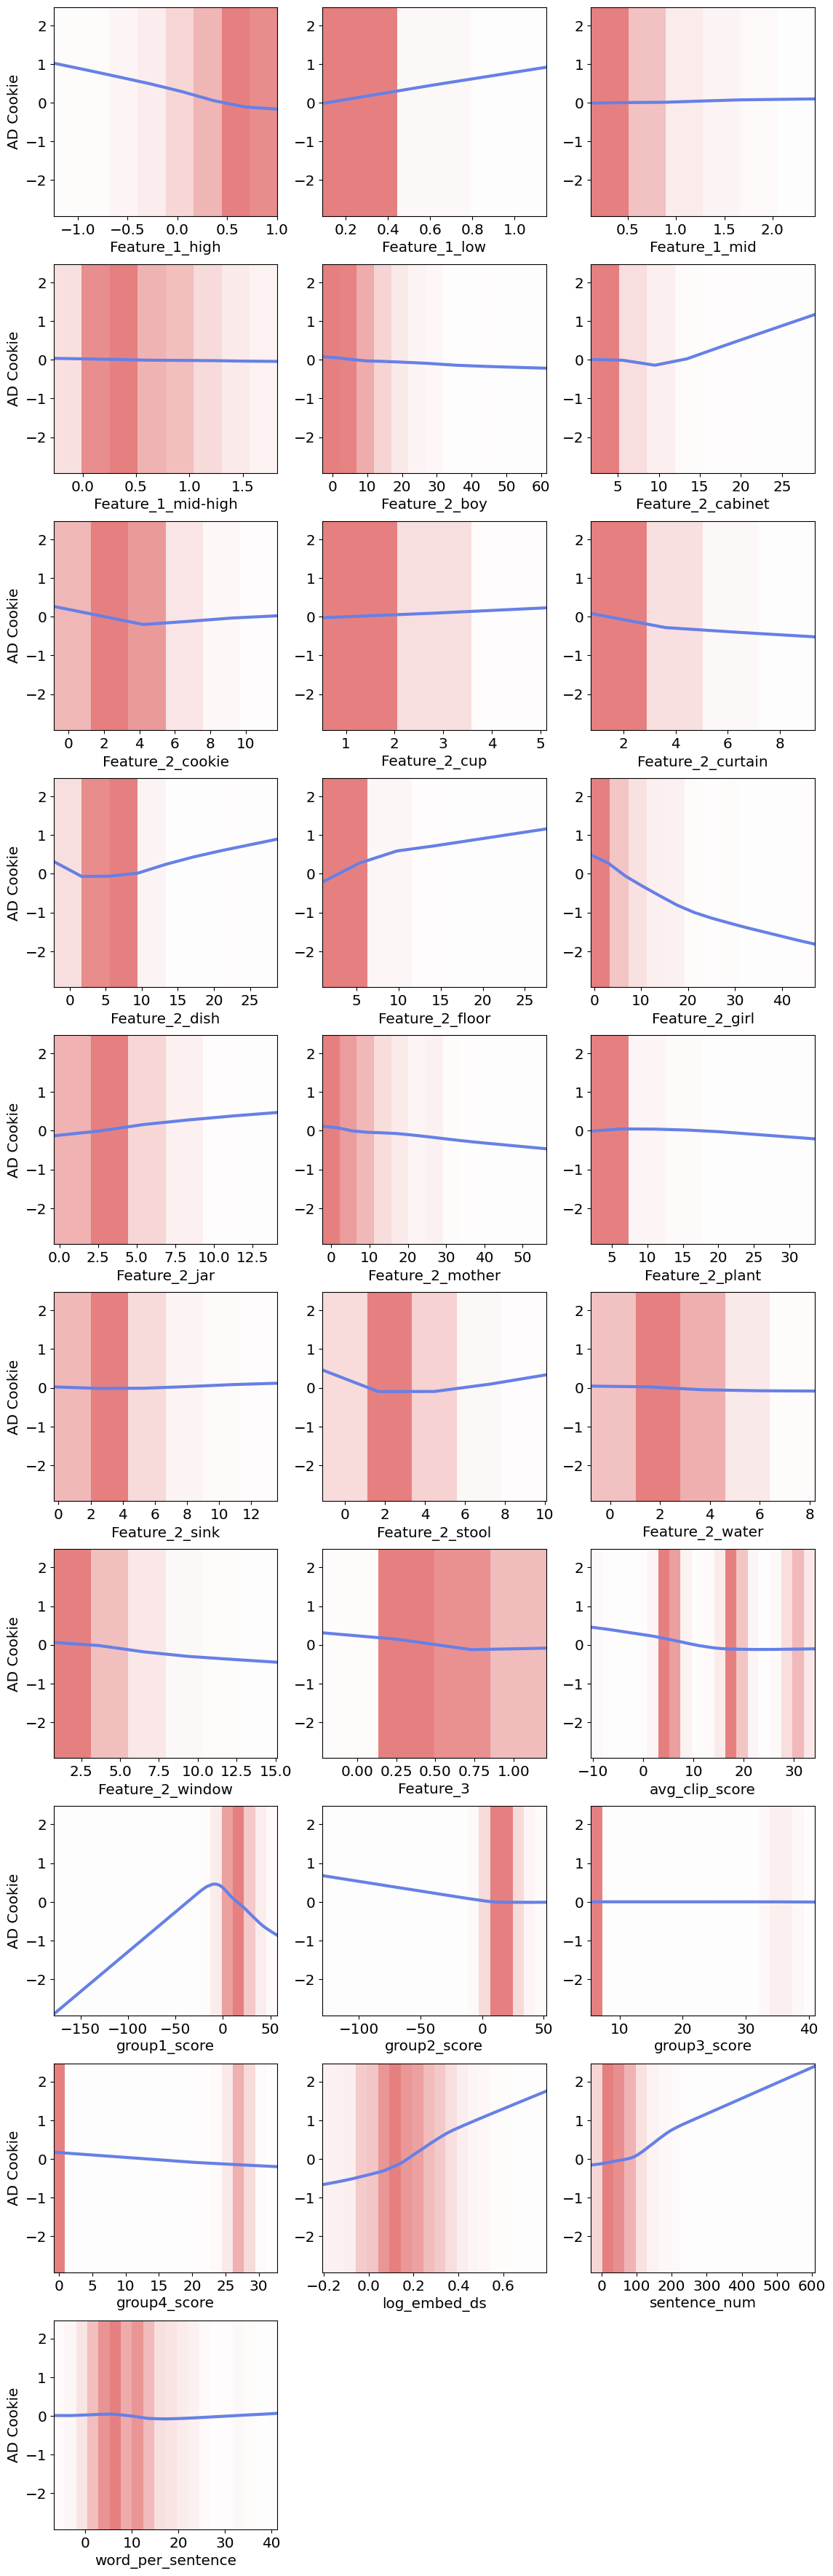

In [69]:
COLORS = [[0.9, 0.4, 0.5], [0.5, 0.9, 0.4], [0.4, 0.5, 0.9], [0.9, 0.5, 0.9]]
NUM_COLS =  3#@param {'type': 'integer'}
N_BLOCKS =  20#@param
MIN_Y = None
MAX_Y = None
NUM_ROWS = int(np.ceil(NUM_FEATURES / NUM_COLS))
fig = plt.figure(num=None, figsize=(NUM_COLS * 4.5, NUM_ROWS * 4.5),
                 facecolor='w', edgecolor='k')

MIN_Y, MAX_Y = plot_all_hist(avg_hist_data, NUM_ROWS, NUM_COLS, COLORS[2],
                             min_y=MIN_Y, max_y=MAX_Y, feature_to_use=column_names)
shade_by_density_blocks(avg_hist_data, NUM_ROWS, NUM_COLS, n_blocks=N_BLOCKS, feature_to_use=column_names)

# This is for plotting individual plots when there are multiple models
"""
for pred in feature_predictions:
  model_hist = {col: pred[0, i] for i, col in enumerate(column_names)}
  plot_all_hist(model_hist, NUM_ROWS, NUM_COLS,
                color_base=[0.3, 0.4, 0.9, 0.2], alpha=0.06,
                linewidth=0.1, min_y=MIN_Y, max_y=MAX_Y, feature_to_use=features)
"""
plt.subplots_adjust(hspace=0.23)
plt.show()

In [31]:
col_min_max

{'Feature_1_high': (0.125, 1.0),
 'Feature_1_mid-high': (0.0, 1.0),
 'Feature_1_mid': (0.0, 0.75),
 'Feature_1_low': (0.0, 0.222),
 'Feature_2_mother': (0, 15),
 'Feature_2_jar': (0, 5),
 'Feature_2_dish': (0, 8),
 'Feature_2_cookie': (0, 5),
 'Feature_2_water': (0, 4),
 'Feature_2_stool': (0, 4),
 'Feature_2_boy': (0, 15),
 'Feature_2_sink': (0, 5),
 'Feature_2_window': (0, 5),
 'Feature_2_cabinet': (0, 7),
 'Feature_2_cup': (0, 2),
 'Feature_2_plant': (0, 7),
 'Feature_2_girl': (0, 13),
 'Feature_2_curtain': (0, 3),
 'Feature_2_floor': (0, 6),
 'Feature_3': (0.25, 1.0),
 'log_embed_ds': (0.0122, 0.2946),
 'sentence_num': (4, 105),
 'word_per_sentence': (2.3333, 15.875),
 'group1_score': (0.0, 28.7233),
 'group2_score': (0.0, 30.5827),
 'group3_score': (0.0, 26.6377),
 'group4_score': (0.0, 27.8953),
 'avg_clip_score': (4.9112, 25.2025)}